# Clasificador K-Means
Una guía completa para implementar y comprender el agrupamiento K-means utilizando scikit-learn.

## 1. Importación de Bibliotecas Necesarias
Comenzaremos importando todas las bibliotecas Python necesarias para nuestra implementación de agrupamiento K-means.

In [ ]:
# Importar bibliotecas estándar para manipulación de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 6)

# Importar módulos de scikit-learn para K-means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import make_blobs, load_iris, fetch_openml

## 2. Entendiendo K-means Clustering

K-means es uno de los algoritmos de aprendizaje automático no supervisado más simples y populares para análisis de agrupamiento. El objetivo principal es particionar n observaciones en k grupos donde cada observación pertenece al grupo con la media (centroide) más cercana.

### El Algoritmo K-means:

1. **Inicialización de Centroides**: 
   - Seleccionar k centroides iniciales aleatoriamente o usando métodos como k-means++

2. **Paso de Asignación**: 
   - Asignar cada punto de datos al centroide más cercano
   - Esto forma k grupos

3. **Paso de Actualización**: 
   - Recalcular los centroides como la media de todos los puntos en cada grupo

4. **Convergencia**: 
   - Repetir los pasos 2-3 hasta que los centroides ya no cambien significativamente o se alcance el máximo de iteraciones

### Limitaciones de K-means:
- Requiere que se especifique de antemano el número de grupos (k)
- Es sensible a la ubicación inicial de los centroides
- Asume que los grupos son esféricos y de tamaño similar
- Es sensible a los valores atípicos

### El Método Elbow:
El método del codo ayuda a determinar el número óptimo de grupos graficando la variación explicada como función del número de grupos. El punto donde la curva comienza a aplanarse se considera el número óptimo de grupos.

## 3. Carga y Exploración del Dataset

Para este tutorial, usaremos dos conjuntos de datos:
1. Un conjunto de datos sintético para ilustrar claramente el comportamiento de K-means
2. El conjunto de datos Iris, un conjunto de datos clásico para agrupamiento y clasificación

Comencemos con el conjunto de datos sintético.

Resumen del Conjunto de Datos Sintético:


,Feature 1,Feature 2,TrueCluster
0,-9.113944,6.813616,3
1,-9.354576,7.092790,3
2,-2.015671,8.281780,0
3,-7.010236,-6.220843,2
4,-10.061202,6.718671,3


,Feature 1,Feature 2,TrueCluster
count,300.000000,300.000000,300.000000
mean,-3.401029,2.850284,1.500000
std,5.225108,6.198816,1.119902
min,-10.321314,-8.103649,0.000000
25%,-7.863925,-0.804732,0.750000
50%,-4.823395,5.113589,1.500000
75%,-0.359335,8.168472,2.250000
max,6.028674,10.492231,3.000000


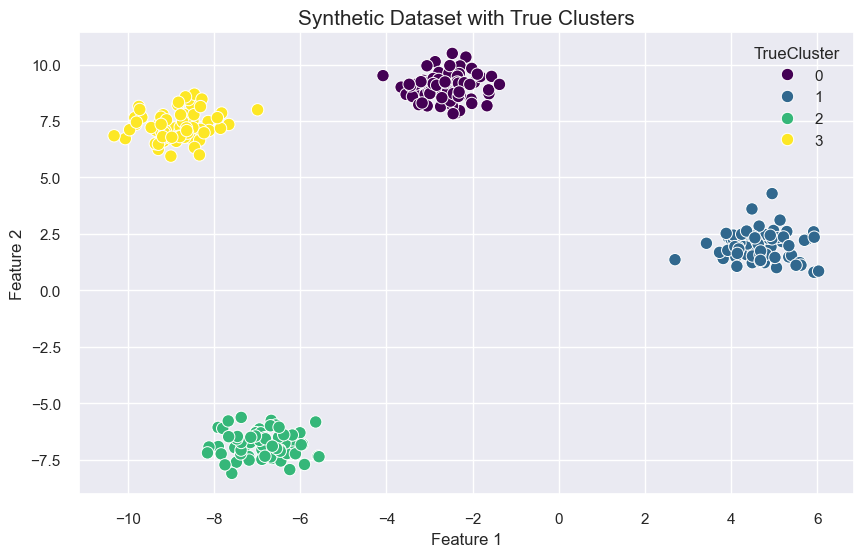

In [27]:
# Generar datos sintéticos con clear clusters
X_synthetic, y_true = make_blobs(
    n_samples=300, 
    n_features=2, 
    centers=4, 
    cluster_std=0.60, 
    random_state=42
)

# Convertir a DataFrame para facilitar la manipulación
df_synthetic = pd.DataFrame(X_synthetic, columns=['Feature 1', 'Feature 2'])
df_synthetic['TrueCluster'] = y_true

# Mostrar las primeras filas
print("Resumen del Conjunto de Datos Sintético:")
display(df_synthetic.head())

# Descripción estadística básica
display(df_synthetic.describe())

# Visualizar los datos sintéticos con etiquetas de grupos verdaderos
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_synthetic, x='Feature 1', y='Feature 2', hue='TrueCluster', palette='viridis', s=80)
plt.title('Synthetic Dataset with True Clusters', fontsize=15)
plt.show()

Resumen del Conjunto de Datos Iris:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


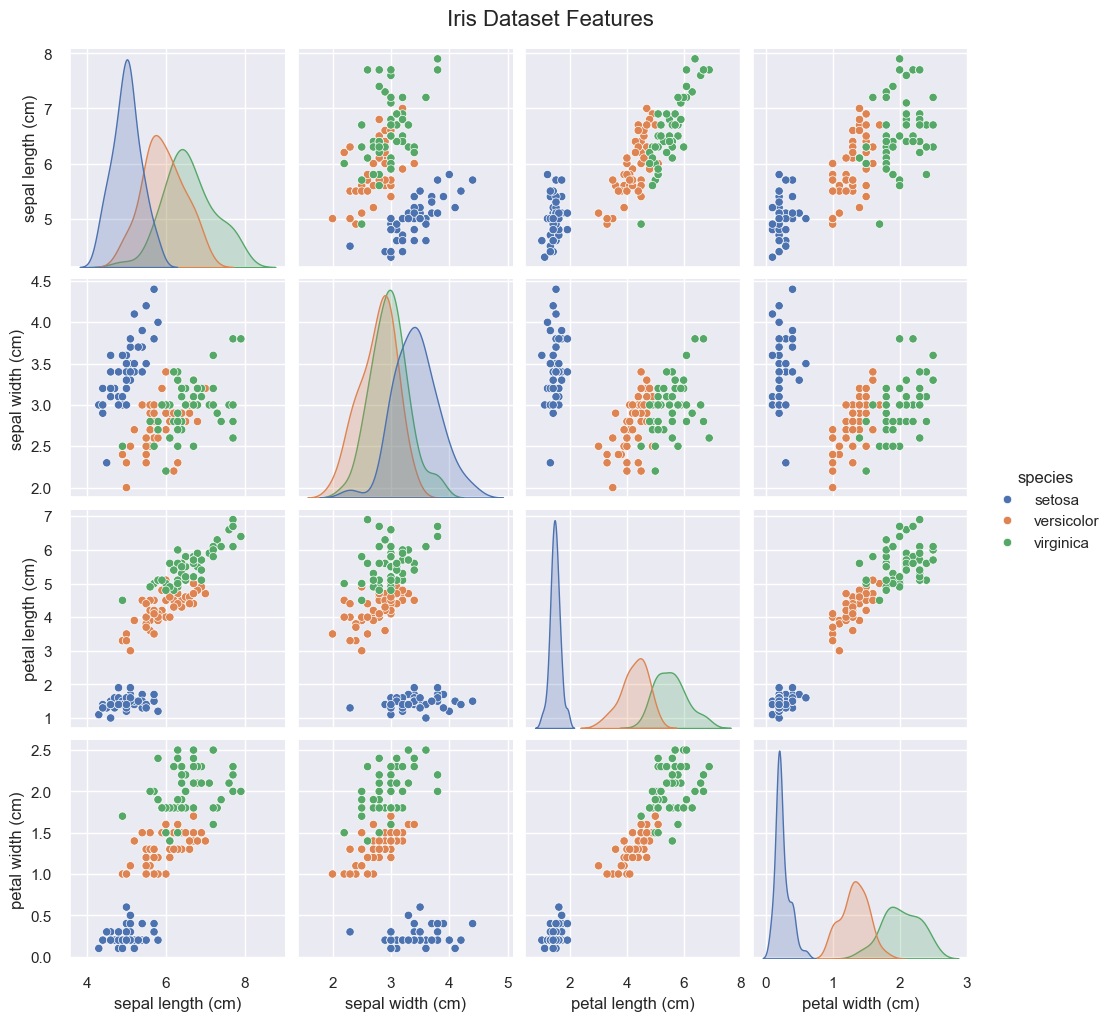

In [28]:
# Ahora carguemos el Iris dataset
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Mostrar las primeras filas
print("Resumen del Conjunto de Datos Iris:")
display(df_iris.head())

# Descripción estadística básica
display(df_iris.describe())

# Visualizar pairplot para ver relaciones entre características
sns.pairplot(df_iris, hue='species', height=2.5)
plt.suptitle('Iris Dataset Features', y=1.02, fontsize=16)
plt.show()

## 4. Preprocesamiento de Datos

El preprocesamiento es especialmente importante para el agrupamiento K-means porque:

1. **Feature Scaling**: K-means utiliza la distancia euclidiana, por lo que las características con escalas más grandes pueden dominar el cálculo de la distancia
2. **Handling Missing Values**: K-means no puede manejar valores faltantes directamente
3. **Outlier Treatment**: K-means es sensible a los valores atípicos ya que pueden afectar significativamente las posiciones de los centroides

Preprocesemos nuestros conjuntos de datos:

In [29]:
# Verificar valores faltantes en el conjunto de datos Iris
print("Valores faltantes en el conjunto de datos Iris:", df_iris.isnull().sum().sum())

# No hay valores faltantes en Iris, pero demostremos el escalado
# Para K-means, StandardScaler es a menudo preferido ya que da media cero y varianza unitaria
# Crear escaladores separados para cada conjunto de datos para evitar sobrescritura
iris_scaler = StandardScaler()
synthetic_scaler = StandardScaler()

# Escalar el conjunto de datos Iris (excluyendo la columna de especies)
iris_features = df_iris.drop('species', axis=1)
iris_scaled = iris_scaler.fit_transform(iris_features)
df_iris_scaled = pd.DataFrame(iris_scaled, columns=iris_features.columns)

# Mostrar los datos escalados
print("Conjunto de Datos Iris Escalado:")
display(df_iris_scaled.head())
display(df_iris_scaled.describe())

# De manera similar, escalemos el conjunto de datos sintético
synthetic_features = df_synthetic.drop('TrueCluster', axis=1)
synthetic_scaled = synthetic_scaler.fit_transform(synthetic_features)
df_synthetic_scaled = pd.DataFrame(synthetic_scaled, columns=synthetic_features.columns)

# Mostrar los datos escalados
print("Conjunto de Datos Sintético Escalado:")
display(df_synthetic_scaled.head())
display(df_synthetic_scaled.describe())

Valores faltantes en el conjunto de datos Iris: 0
Conjunto de Datos Iris Escalado:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-1.468455e-15,-1.823726e-15,-1.610564e-15,-9.473903e-16
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00
min,-1.870024e+00,-2.433947e+00,-1.567576e+00,-1.447076e+00
25%,-9.006812e-01,-5.923730e-01,-1.226552e+00,-1.183812e+00
50%,-5.250608e-02,-1.319795e-01,3.364776e-01,1.325097e-01
75%,6.745011e-01,5.586108e-01,7.627583e-01,7.906707e-01
max,2.492019e+00,3.090775e+00,1.785832e+00,1.712096e+00


Conjunto de Datos Sintético Escalado:


,Feature 1,Feature 2
0,-1.095185,0.640437
1,-1.141315,0.685549
2,0.265578,0.877679
3,-0.691897,-1.465810
4,-1.276778,0.625095


,Feature 1,Feature 2
count,3.000000e+02,3.000000e+02
mean,2.368476e-17,2.960595e-17
std,1.001671e+00,1.001671e+00
min,-1.326642e+00,-1.770053e+00
25%,-8.555521e-01,-5.906164e-01
50%,-2.726723e-01,3.657290e-01
75%,5.831031e-01,8.593695e-01
max,1.807706e+00,1.234867e+00


## 5. Implementación de K-means usando Scikit-learn

Ahora implementaremos el agrupamiento K-means usando scikit-learn. Aquí están los parámetros importantes:

- **n_clusters**: El número de grupos a formar y centroides a generar
- **init**: Método para la inicialización ('k-means++' o 'random')
- **n_init**: Número de veces que el algoritmo se ejecutará con diferentes semillas de centroides
- **max_iter**: Número máximo de iteraciones para una sola ejecución
- **random_state**: Semilla para la generación de números aleatorios para la inicialización de centroides

Comencemos aplicando K-means a nuestro conjunto de datos sintético:

Número de iteraciones requeridas: 2
Inercia final (suma de distancias cuadradas): 6.42


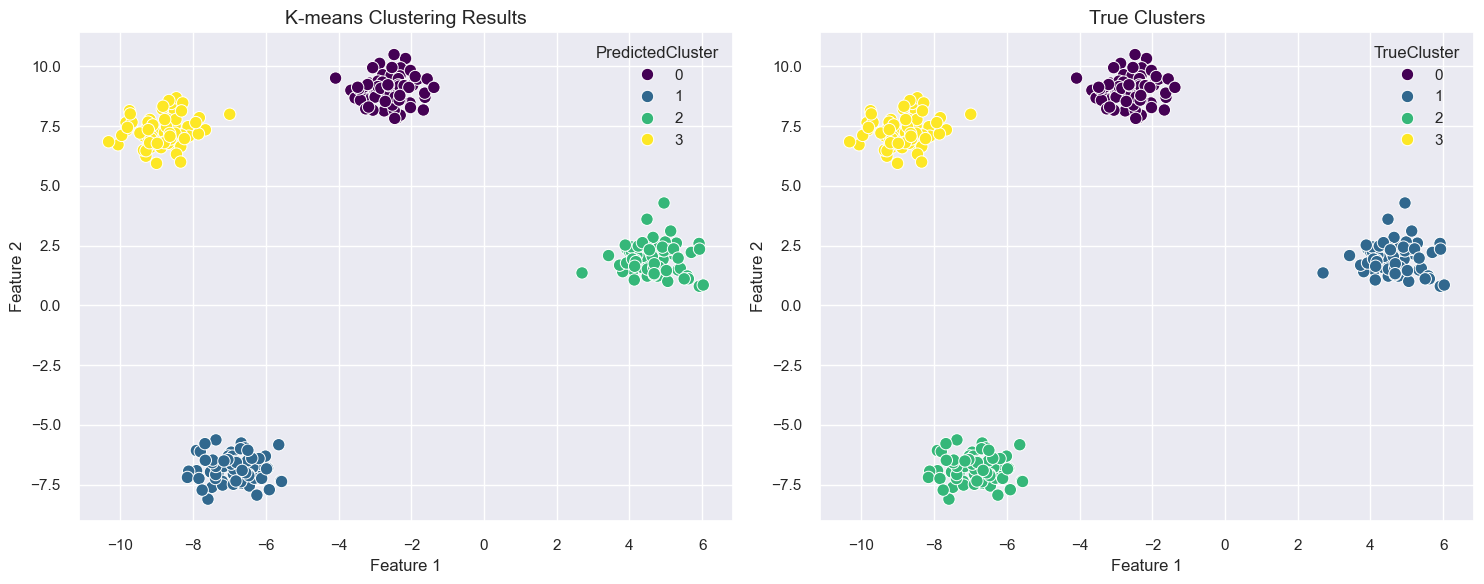

Índice Rand Ajustado: 1.0000 (1.0 es agrupamiento perfecto)


In [30]:
# Inicializar K-means con 4 grupos (sabemos el número verdadero para los datos sintéticos)
kmeans_synthetic = KMeans(
    n_clusters=4,
    init='k-means++',  # Inicialización inteligente para evitar mal agrupamiento
    n_init=10,         # Ejecutar el algoritmo 10 veces con diferentes semillas
    max_iter=300,      # Iteraciones máximas por ejecución
    random_state=42    # Para reproducibilidad
)

# Ajustar el modelo a nuestros datos sintéticos escalados
kmeans_synthetic.fit(df_synthetic_scaled)

# Obtener etiquetas de grupos y centroides
synthetic_labels = kmeans_synthetic.labels_
synthetic_centroids = kmeans_synthetic.cluster_centers_

# Agregar etiquetas de grupos al dataframe original
df_synthetic['PredictedCluster'] = synthetic_labels

# Mostrar información de grupos
print(f"Número de iteraciones requeridas: {kmeans_synthetic.n_iter_}")
print(f"Inercia final (suma de distancias cuadradas): {kmeans_synthetic.inertia_:.2f}")

# Visualizar resultados de agrupamiento
plt.figure(figsize=(15, 6))

# Características originales con grupos predichos
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_synthetic, 
    x='Feature 1', 
    y='Feature 2', 
    hue='PredictedCluster', 
    palette='viridis',
    s=80
)
plt.title('K-means Clustering Results', fontsize=14)

# Características originales con grupos verdaderos
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_synthetic, 
    x='Feature 1', 
    y='Feature 2', 
    hue='TrueCluster', 
    palette='viridis',
    s=80
)
plt.title('True Clusters', fontsize=14)

plt.tight_layout()
plt.show()

# Calcular la precisión del agrupamiento (normalmente no posible en casos reales de aprendizaje no supervisado)
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(df_synthetic['TrueCluster'], df_synthetic['PredictedCluster'])
print(f"Índice Rand Ajustado: {ari:.4f} (1.0 es agrupamiento perfecto)")

Predicted Cluster,0,1,2
Actual Species,,,
setosa,0,50,0
versicolor,39,0,11
virginica,14,0,36


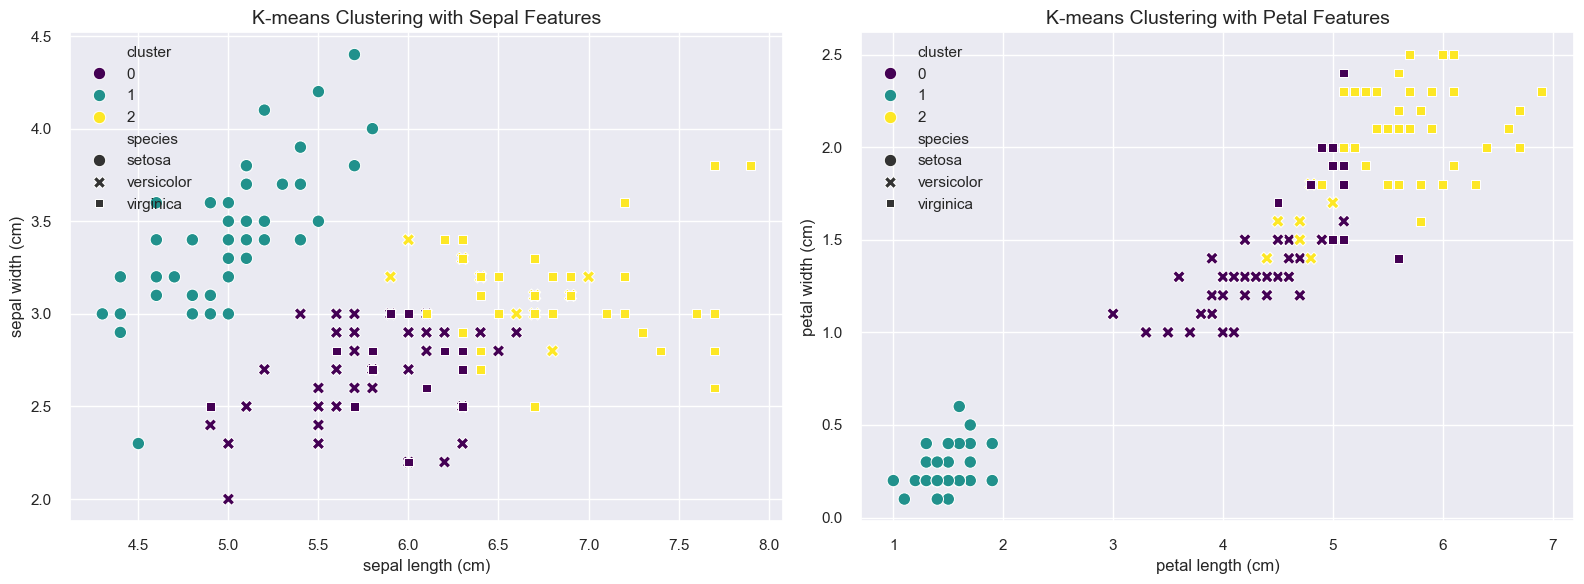

Índice Rand Ajustado para Iris: 0.6201


In [31]:
# Ahora apliquemos K-means al conjunto de datos Iris
# Sabemos que Iris tiene 3 especies, así que usemos 3 grupos
kmeans_iris = KMeans(
    n_clusters=3, 
    init='k-means++', 
    n_init=10, 
    max_iter=300, 
    random_state=42
)

# Ajustar a datos escalados
kmeans_iris.fit(df_iris_scaled)

# Obtener etiquetas de grupos y agregar al dataframe
df_iris['cluster'] = kmeans_iris.labels_

# Mostrar resultados de grupos vs especies reales
result_table = pd.crosstab(df_iris['species'], df_iris['cluster'], 
                          rownames=['Actual Species'], 
                          colnames=['Predicted Cluster'])
display(result_table)

# Visualizar en 2D usando las primeras dos características
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_iris, 
    x='sepal length (cm)', 
    y='sepal width (cm)', 
    hue='cluster', 
    style='species',  # Usar forma para mostrar especies verdaderas
    palette='viridis', 
    s=80
)
plt.title('K-means Clustering with Sepal Features', fontsize=14)

plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_iris, 
    x='petal length (cm)', 
    y='petal width (cm)', 
    hue='cluster', 
    style='species',  # Usar forma para mostrar especies verdaderas
    palette='viridis', 
    s=80
)
plt.title('K-means Clustering with Petal Features', fontsize=14)

plt.tight_layout()
plt.show()

# Calcular ARI para el conjunto de datos Iris
ari_iris = adjusted_rand_score(iris.target, kmeans_iris.labels_)
print(f"Índice Rand Ajustado para Iris: {ari_iris:.4f}")

## 6. Creación de un Pipeline para Agrupamiento K-means

El Pipeline de scikit-learn nos permite encadenar múltiples pasos que pueden ser validados cruzadamente en conjunto. Para K-means, podemos crear un pipeline que incluya pasos de preprocesamiento y el algoritmo de agrupamiento.

Pipeline coincide con enfoque manual: False


,n_clusters,inertia
0,2,222.361705
1,3,191.024737
2,4,114.354072
3,5,91.047670
4,6,81.550757
5,7,80.777739
6,8,64.426748
7,9,55.706900
8,10,51.121095


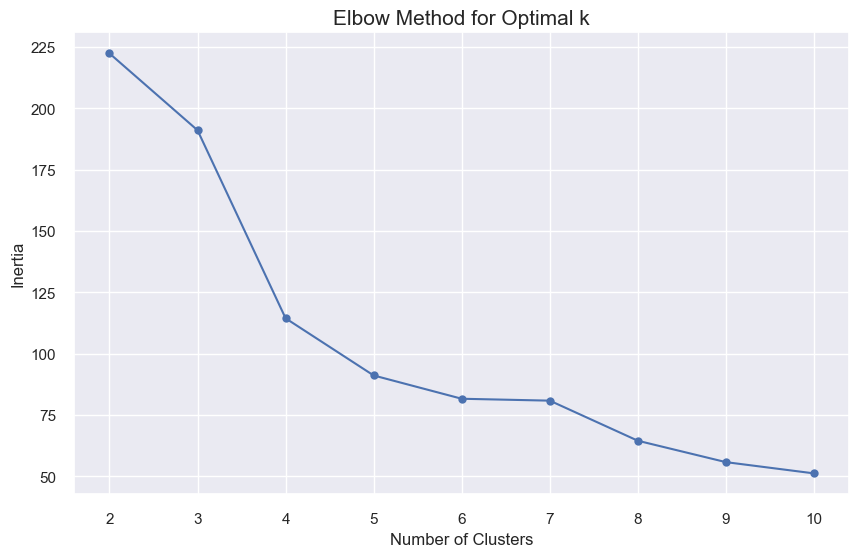

In [32]:
# Crear un pipeline con preprocesamiento (escalado) y agrupamiento K-means
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Paso 1: Estandarizar características
    ('kmeans', KMeans(n_clusters=3, init='k-means++', random_state=42))  # Paso 2: Aplicar K-means
])

# Aplicar el pipeline al conjunto de datos Iris (sin escalar)
kmeans_pipeline.fit(iris_features)

# Obtener las etiquetas de los grupos
pipeline_labels = kmeans_pipeline.named_steps['kmeans'].labels_

# Comparar con nuestro enfoque manual
print("Pipeline coincide con enfoque manual:", np.array_equal(pipeline_labels, kmeans_iris.labels_))

# Podemos cambiar fácilmente los parámetros en el pipeline
# Por ejemplo, probar con diferentes números de grupos
results = []
for n_clusters in range(2, 11):
    kmeans_pipeline.set_params(kmeans__n_clusters=n_clusters)
    kmeans_pipeline.fit(iris_features)
    inertia = kmeans_pipeline.named_steps['kmeans'].inertia_
    results.append({
        'n_clusters': n_clusters,
        'inertia': inertia
    })

# Mostrar resultados
results_df = pd.DataFrame(results)
display(results_df)

# Graficar inercia vs número de grupos
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_clusters'], results_df['inertia'], 'bo-')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=15)
plt.grid(True)
plt.show()

## 7. Determinación del Número Óptimo de Grupos

Encontrar el número correcto de grupos es uno de los mayores desafíos en el agrupamiento K-means. Implementaremos tres métodos comunes:

1. **Elbow Method**: Graficar la inercia (suma de cuadrados dentro del grupo) vs número de grupos
2. **Silhouette Score**: Medida de cuán similar es un objeto a su propio grupo en comparación con otros grupos
3. **Gap Statistic**: Comparar la dispersión dentro del grupo con la esperada bajo una distribución nula de referencia

,n_clusters,inertia,silhouette_score,davies_bouldin
0,2,222.361705,0.581750,0.593313
1,3,139.820496,0.459948,0.833595
2,4,114.092547,0.386941,0.869814
3,5,90.927514,0.345901,0.948317
4,6,81.544391,0.317079,1.053677
5,7,72.631144,0.320197,0.990528
6,8,62.540606,0.338692,0.914982
7,9,55.119493,0.342360,0.903152
8,10,47.391035,0.351793,0.874825


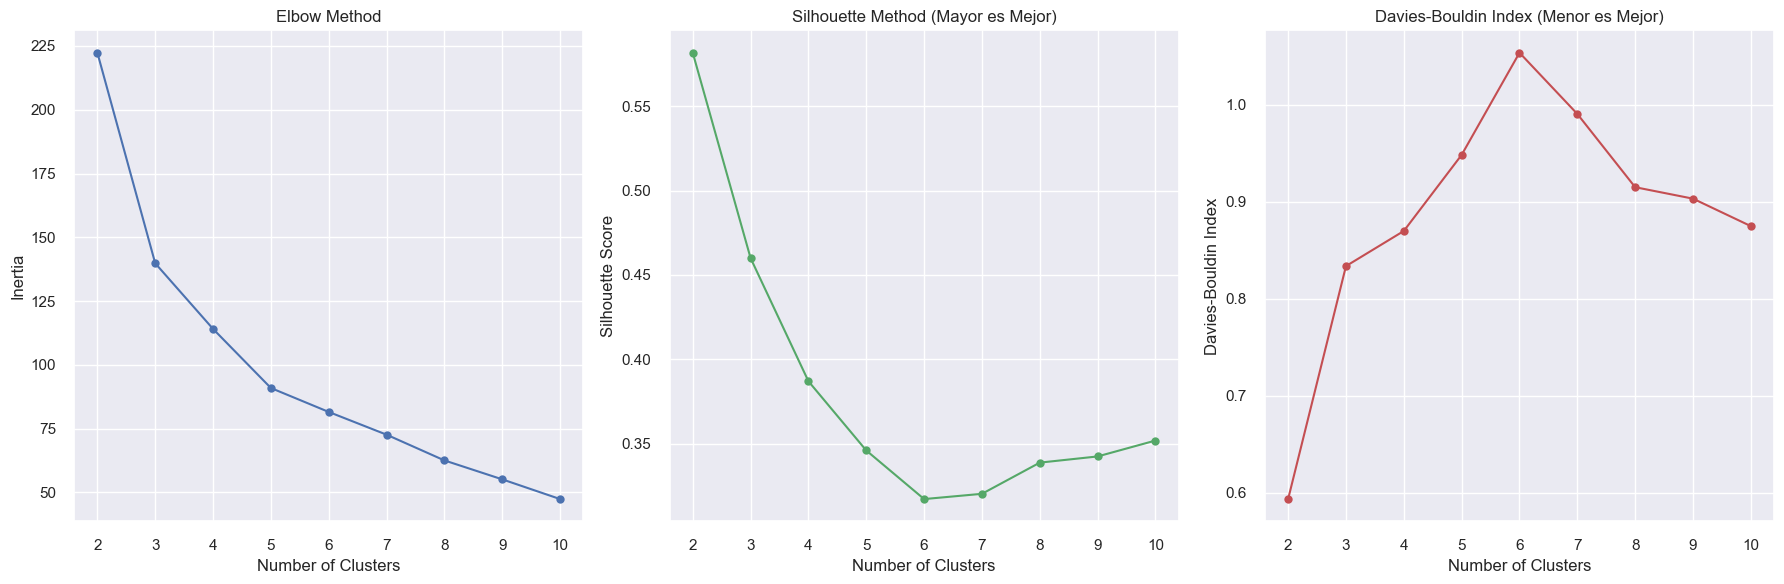

Número óptimo de grupos basado en:
1. Elbow Method: Buscar la curva en la flexión (alrededor de 3 clusters)
2. Silhouette Score: Valor máximo en 2 clusters (puntuación: 0.5818)
3. Davies-Bouldin: Valor mínimo en 2 clusters (puntuación: 0.5933)


In [33]:
# Apliquemos estos métodos para determinar el número óptimo de grupos para el conjunto de datos Iris

# Función para calcular métricas para diferentes números de grupos
def compute_clustering_metrics(data, max_clusters=10):
    """Calcular inercia y puntuación de silueta para diferentes números de grupos"""
    metrics = []
    
    range_n_clusters = range(2, max_clusters + 1)
    for n_clusters in range_n_clusters:
        # Inicializar y ajustar KMeans
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calcular métricas
        silhouette_avg = silhouette_score(data, cluster_labels)
        davies_bouldin = davies_bouldin_score(data, cluster_labels)
        
        metrics.append({
            'n_clusters': n_clusters,
            'inertia': kmeans.inertia_,
            'silhouette_score': silhouette_avg,
            'davies_bouldin': davies_bouldin
        })
    
    return pd.DataFrame(metrics)

# Calcular métricas para el conjunto de datos Iris
iris_metrics = compute_clustering_metrics(df_iris_scaled)
display(iris_metrics)

# Crear gráficos para cada métrica
plt.figure(figsize=(18, 6))

# Elbow Method - Inertia
plt.subplot(1, 3, 1)
plt.plot(iris_metrics['n_clusters'], iris_metrics['inertia'], 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

# Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(iris_metrics['n_clusters'], iris_metrics['silhouette_score'], 'go-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method (Mayor es Mejor)')
plt.grid(True)

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(iris_metrics['n_clusters'], iris_metrics['davies_bouldin'], 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index (Menor es Mejor)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Basado en estas métricas, podemos determinar el número óptimo de grupos
print("Número óptimo de grupos basado en:")
print(f"1. Elbow Method: Buscar la curva en la flexión (alrededor de 3 clusters)")
print(f"2. Silhouette Score: Valor máximo en {iris_metrics['silhouette_score'].idxmax() + 2} clusters "
      f"(puntuación: {iris_metrics['silhouette_score'].max():.4f})")
print(f"3. Davies-Bouldin: Valor mínimo en {iris_metrics['davies_bouldin'].idxmin() + 2} clusters "
      f"(puntuación: {iris_metrics['davies_bouldin'].min():.4f})")

## 8. Visualización de los Grupos

Hay muchas formas de visualizar los resultados del agrupamiento. Exploraremos algunas técnicas:

1. Gráficos de dispersión para datos 2D
2. PCA para reducción de dimensionalidad para visualizar datos de alta dimensión
3. Visualización de centroides de grupos

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


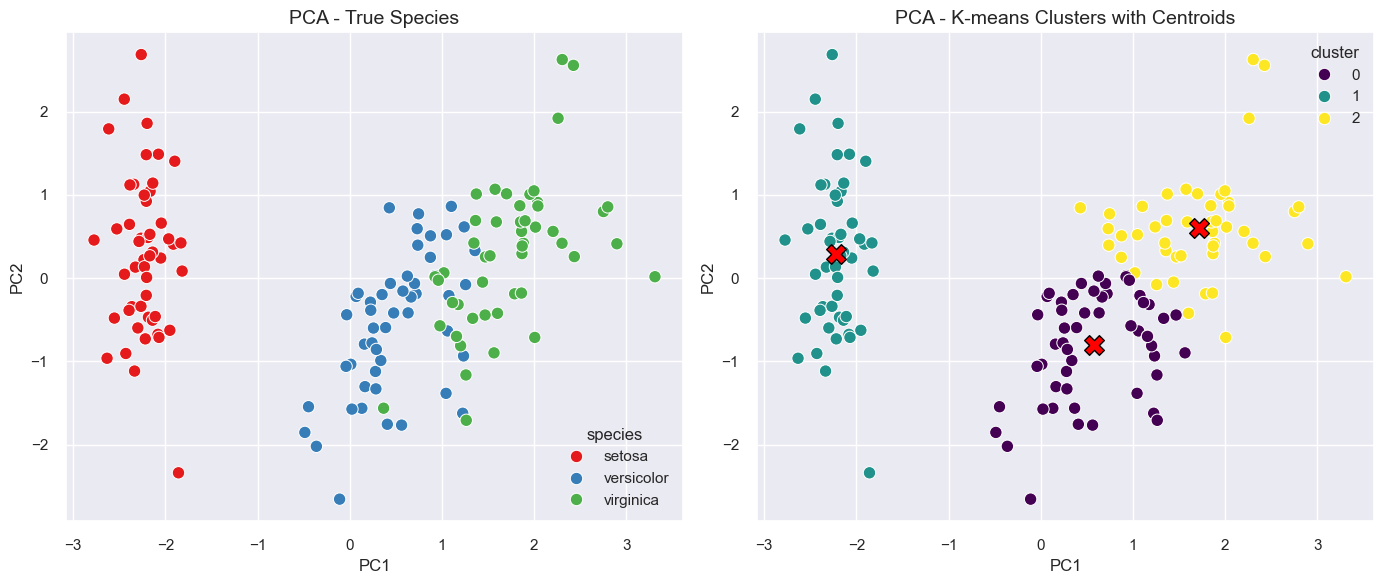

Ratio de varianza explicada por componentes PCA:
PC1: 0.7296
PC2: 0.2285
Total: 0.9581


,PC1,PC2
sepal length (cm),0.521066,0.377418
sepal width (cm),-0.269347,0.923296
petal length (cm),0.580413,0.024492
petal width (cm),0.564857,0.066942


In [34]:
# Para el conjunto de datos Iris, tenemos 4 dimensiones
# Usemos PCA para reducir a 2 dimensiones para visualización

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
iris_pca = pca.fit_transform(df_iris_scaled)

# Crear un dataframe con resultados PCA
df_pca = pd.DataFrame(iris_pca, columns=['PC1', 'PC2'])
df_pca['species'] = df_iris['species']
df_pca['cluster'] = kmeans_iris.labels_

# Ahora visualicemos los grupos en las dimensiones reducidas
plt.figure(figsize=(14, 6))

# Gráfico PCA con especies verdaderas
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='species',
    s=80,
    palette='Set1'
)
plt.title('PCA - True Species', fontsize=14)

# Gráfico PCA con grupos K-means
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='cluster',
    s=80,
    palette='viridis'
)

# Agregar centroides al gráfico
# Necesitamos transformar los centroides usando el mismo PCA
centroids_pca = pca.transform(kmeans_iris.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=200,
    marker='X',
    color='red',
    edgecolor='black'
)
plt.title('PCA - K-means Clusters with Centroids', fontsize=14)

plt.tight_layout()
plt.show()

# Ratio de varianza explicada
print("Ratio de varianza explicada por componentes PCA:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Total: {sum(pca.explained_variance_ratio_):.4f}")

# Contribución de características a componentes principales
feature_names = iris_features.columns
component_df = pd.DataFrame({
    'PC1': pca.components_[0],
    'PC2': pca.components_[1]
}, index=feature_names)

display(component_df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
Cluster 0,5.801887,2.673585,4.369811,1.413208
Cluster 1,5.006000,3.428000,1.462000,0.246000
Cluster 2,6.780851,3.095745,5.510638,1.972340


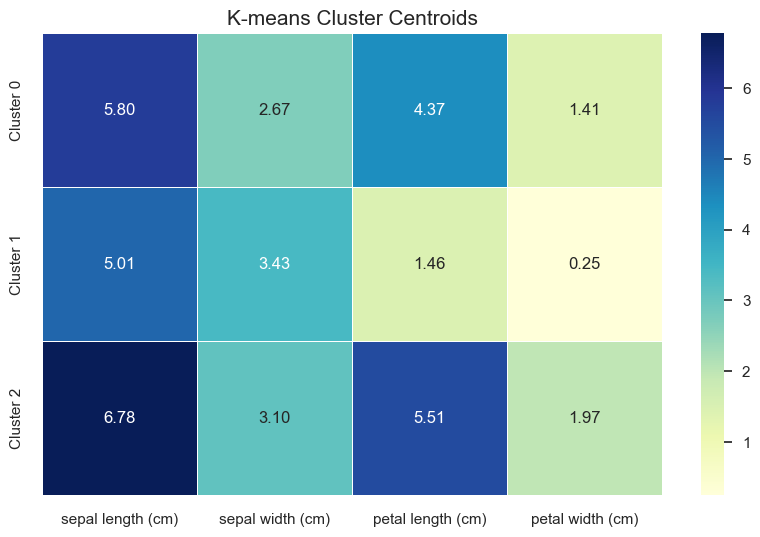

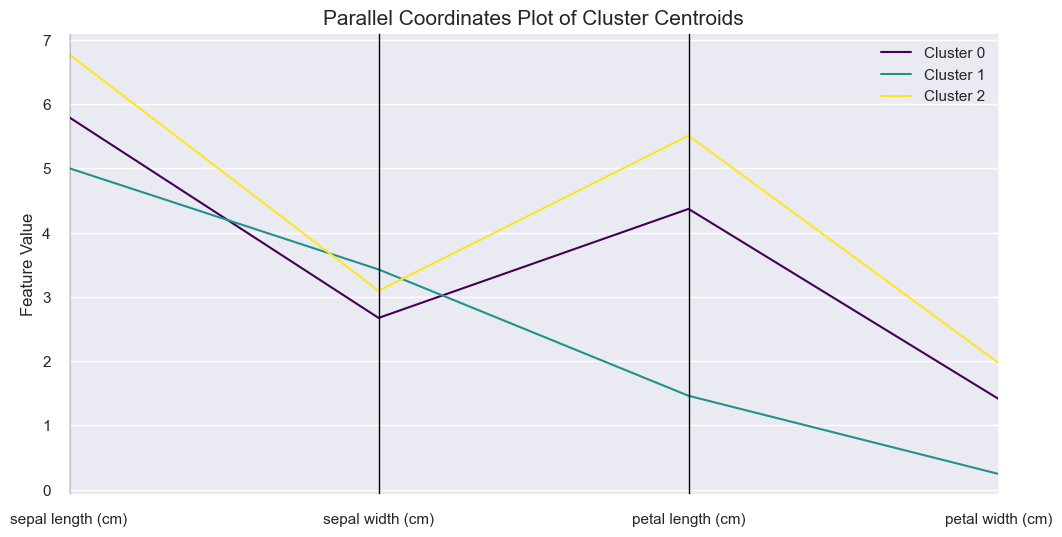

In [35]:
# Visualicemos los centroides de grupos en el espacio de características original
# Esto ayuda a entender qué representa cada grupo

# Transformar centroides de vuelta a escala original
centroids_original = iris_scaler.inverse_transform(kmeans_iris.cluster_centers_)
centroids_df = pd.DataFrame(centroids_original, columns=iris_features.columns)
centroids_df.index = [f'Cluster {i}' for i in range(len(centroids_df))]

# Mostrar centroides en escala original
display(centroids_df)

# Visualizar centroides con un mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(centroids_df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('K-means Cluster Centroids', fontsize=15)
plt.show()

# Crear un gráfico de coordenadas paralelas para visualizar centroides
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(
    centroids_df.reset_index(),
    'index',
    colormap=plt.cm.viridis
)
plt.title('Parallel Coordinates Plot of Cluster Centroids', fontsize=15)
plt.ylabel('Feature Value')
plt.grid(True)
plt.show()

## 9. Evaluación de los Resultados del Agrupamiento

Evaluar la calidad del agrupamiento es un desafío en el aprendizaje no supervisado ya que no tenemos etiquetas verdaderas. Sin embargo, varias métricas pueden ayudarnos a evaluar la calidad de nuestros grupos:

1. **Inercia**: Suma de distancias cuadradas al centroide más cercano (menor es mejor, pero disminuye con más grupos)
2. **Puntuación de Silueta**: Mide cuán similar es un objeto a su propio grupo en comparación con otros (mayor es mejor)
3. **Índice Davies-Bouldin**: Relación de similitud promedio de cada grupo con su grupo más similar (menor es mejor)

Cuando las etiquetas verdaderas están disponibles (como en nuestro caso con el conjunto de datos Iris), también podemos usar:
4. **Índice Rand Ajustado (ARI)**: Mide la similitud entre dos agrupamientos (varía de -1 a 1)
5. **Información Mutua Normalizada (NMI)**: Mide la información mutua entre dos agrupamientos (varía de 0 a 1)

Métricas de Evaluación de Agrupamiento para el Conjunto de Datos Iris:
Inercia: 139.82
Puntuación de Silueta: 0.4599
Índice Davies-Bouldin: 0.8336
Índice Rand Ajustado: 0.6201
Información Mutua Normalizada: 0.6595

Matriz de Confusión (Etiquetas verdaderas vs asignaciones de grupo):


,Cluster 0,Cluster 1,Cluster 2
True Class 0,0,50,0
True Class 1,39,0,11
True Class 2,14,0,36


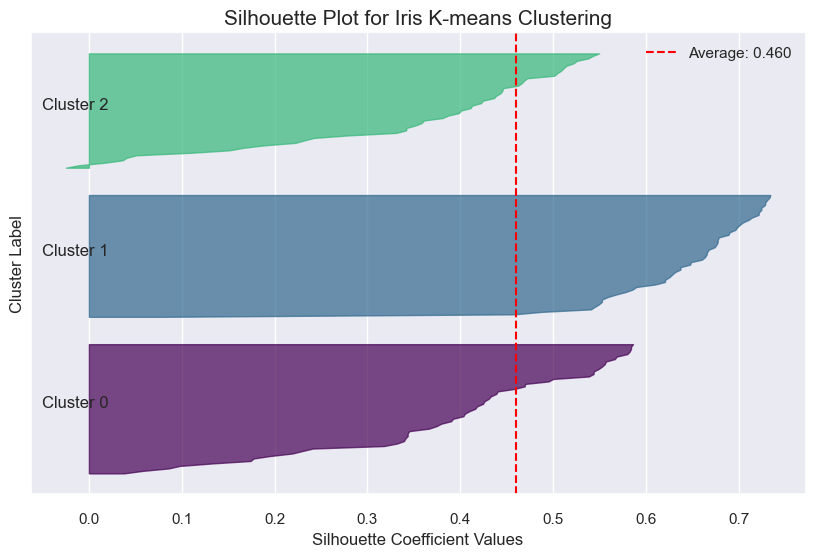


Resumen de Evaluación de Agrupamiento:
------------------------------
El agrupamiento K-means funcionó bien en el conjunto de datos Iris, encontrando 3 grupos que se alinean estrechamente con las tres especies.
La puntuación de silueta relativamente alta indica grupos bien separados.
Las clasificaciones erróneas más significativas ocurren entre las especies versicolor y virginica, como se ve en la matriz de confusión.
Esto se alinea con nuestras observaciones visuales de los gráficos PCA, donde estas dos especies tienen cierta superposición.


In [36]:
# Evaluemos nuestro agrupamiento K-means en el conjunto de datos Iris

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)

# Ya que conocemos las etiquetas verdaderas para Iris, podemos comparar con nuestro agrupamiento
true_labels = iris.target
predicted_labels = kmeans_iris.labels_

# Calcular métricas de evaluación
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)

# Crear una matriz de confusión (requiere algunos ajustes ya que las etiquetas de grupo podrían estar permutadas)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Imprimir resultados de evaluación
print(f"Métricas de Evaluación de Agrupamiento para el Conjunto de Datos Iris:")
print(f"Inercia: {kmeans_iris.inertia_:.2f}")
print(f"Puntuación de Silueta: {silhouette_score(df_iris_scaled, predicted_labels):.4f}")
print(f"Índice Davies-Bouldin: {davies_bouldin_score(df_iris_scaled, predicted_labels):.4f}")
print(f"Índice Rand Ajustado: {ari:.4f}")
print(f"Información Mutua Normalizada: {nmi:.4f}")

print("\nMatriz de Confusión (Etiquetas verdaderas vs asignaciones de grupo):")
display(pd.DataFrame(
    conf_matrix,
    index=[f'True Class {i}' for i in range(3)],
    columns=[f'Cluster {i}' for i in range(3)]
))

# Visualizar puntuaciones de silueta para muestras individuales
from sklearn.metrics import silhouette_samples

# Calcular puntuaciones de silueta para cada muestra
sample_silhouette_values = silhouette_samples(df_iris_scaled, predicted_labels)

# Crear un gráfico de silueta
plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(3):  # Tenemos 3 grupos
    # Obtener puntuaciones de silueta para muestras en el grupo i
    ith_cluster_silhouette_values = sample_silhouette_values[predicted_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(i / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Etiquetar los gráficos de silueta con números de grupo
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    
    # Calcular el nuevo y_lower para el siguiente gráfico
    y_lower = y_upper + 10
    
# El promedio de silueta sobre todas las muestras
silhouette_avg = silhouette_score(df_iris_scaled, predicted_labels)
plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Average: {silhouette_avg:.3f}')

plt.title("Silhouette Plot for Iris K-means Clustering", fontsize=15)
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.yticks([])  # Borrar etiquetas del eje y
plt.legend(loc="best")
plt.show()

# Resumen de evaluación de agrupamiento
print("\nResumen de Evaluación de Agrupamiento:")
print("------------------------------")
print("El agrupamiento K-means funcionó bien en el conjunto de datos Iris, encontrando 3 grupos que se alinean estrechamente con las tres especies.")
print("La puntuación de silueta relativamente alta indica grupos bien separados.")
print("Las clasificaciones erróneas más significativas ocurren entre las especies versicolor y virginica, como se ve en la matriz de confusión.")
print("Esto se alinea con nuestras observaciones visuales de los gráficos PCA, donde estas dos especies tienen cierta superposición.")